In [184]:
# Import the necessary functions from the library
from integration_methods import (
    find_approximate_zeros, find_intervals, trapezoidal_rule, integrate_1d,
    create_uniform_grid, find_valid_cells, integrate_over_cells, integrate_over_cells_quadratic,
    create_uniform_grid_3d, find_valid_cells_3d, integrate_over_cells_trilinear,
    monte_carlo_integration, integrate_using_moments, integrate_using_sub_triangulation,
    find_boundary_points, parametrize_boundary, integrate_over_domain
)

import numpy as np
import matplotlib.pyplot as plt

# Integration Methods for Implicitly Defined Domains

This notebook explores various numerical integration methods for computing integrals over domains implicitly defined by a function $ g(x, y) $. Each method has its advantages and limitations, depending on the properties of $ g(x, y) $, such as smoothness and complexity.

In this notebook, we will cover the following methods:
1. Trapezoidal Rule
2. Quadrature Methods
3. Monte Carlo Integration
4. Moment Fitting
5. Sub-Triangulation
6. Local Parametrization

We will provide recommendations on when to use each method based on the smoothness of $ g(x, y) $ and other relevant factors.

## Step 1: One-Dimensional Case (d = 1)

A suitable subdivision of $\mathbb{R}$ was used to find the implicitly defined domain Ω, followed by the application of Newton-Cotes methods for integration.

We approximate $\int_p^q f(x) \, dx$ using the trapezoidal rule:

$$
\int_p^q f(x) \, dx \approx \frac{h}{2} \left[ f(p) + f(q) + 2 \sum_{i=1}^{n-1} f(p + i \cdot h) \right]
$$

where $ h = \frac{q - p}{n} $ is the width of each subinterval.


In [185]:
# Define the function to be integrated f(x)
def f(x):
    return np.sin(x)  

# Define the implicit function g(x)
def g(x):
    return np.cos(x) - 0.5

# Define the domain [a, b]
a = 0
b = 2 * np.pi

In [186]:
# Calculate the integral
result, trapezoids= integrate_1d(f, g, a, b)
print(f"The integral of f(x) over the domain where g(x) > 0 is approximately: {result}")

The integral of f(x) over the domain where g(x) > 0 is approximately: 1.1102230246251565e-16


### Trapezoidal Rule

The Trapezoidal Rule is a simple and efficient method for numerical integration. It approximates the integral by dividing the domain into trapezoids and summing their areas. This method works well for smooth functions but may not handle sharp boundaries or highly irregular domains accurately.

#### When to Use:
- $g(x, y)$ is smooth and differentiable.
- The domain is relatively simple and does not have sharp corners or irregularities.

Thus, the Trapezoidal Rule is an ideal choice for the example above because both the implicit function $g(x)=cos(x)−0.5$ and the integrand $f(x)=sin(x)$ are smooth and continuous. The domain where $g(x)>0$ results in well-defined, simple intervals, which facilitates the effective application of the Trapezoidal Rule. Moreover, the moderate curvature of $f(x)$ within these intervals ensures that the linear approximation inherent in the Trapezoidal Rule yields a highly accurate result. Consequently, this method efficiently captures the integral with minimal error, demonstrating its suitability for this particular scenario.

#### Strengths: 
- Simple to implement and computationally efficient for one-dimensional integration.

#### Weaknesses: 
- Less accurate for functions with high curvature or discontinuities.

Visualization:

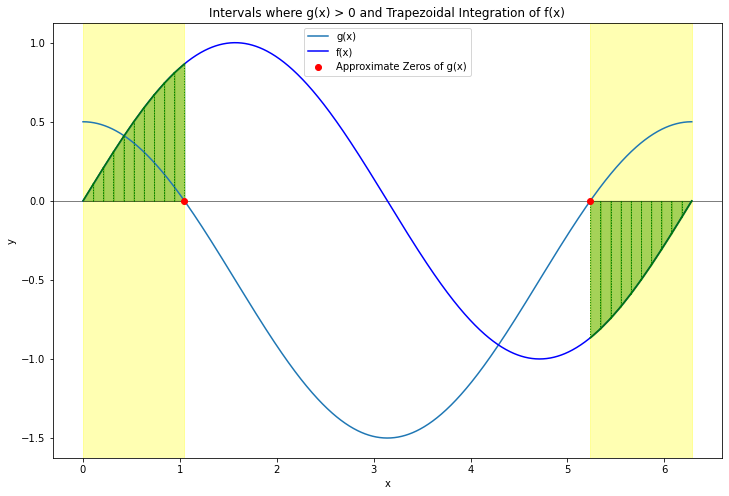

In [187]:
# Plot the function g(x), f(x) and highlight the intervals where g(x) > 0
x = np.linspace(a, b, 1000)
y_g = g(x)
y_f = f(x)

plt.figure(figsize=(12, 8))

# Plot g(x)
plt.plot(x, y_g, label='g(x)')
plt.axhline(0, color='black', linewidth=0.5)
plt.scatter(find_approximate_zeros(g, a, b, 1000), [0] * len(find_approximate_zeros(g, a, b, 1000)), color='red', zorder=5, label='Approximate Zeros of g(x)')

# Highlight intervals where g(x) > 0
intervals = find_intervals(g, a, b, 1000)
for start, end in intervals:
    plt.axvspan(start, end, color='yellow', alpha=0.3)

# Plot f(x)
plt.plot(x, y_f, label='f(x)', color='blue')

# Plot trapezoidal rule approximations
for x_points, y_points in trapezoids:
    for i in range(len(x_points) - 1):
        plt.fill_between([x_points[i], x_points[i+1]], [y_points[i], y_points[i+1]], alpha=0.5, color='green')
        plt.plot([x_points[i], x_points[i + 1]], [y_points[i], y_points[i + 1]], color='green')
        plt.plot([x_points[i], x_points[i]], [0, y_points[i]], color='green', linestyle='dotted', linewidth=1)
        plt.plot([x_points[i + 1], x_points[i + 1]], [0, y_points[i + 1]], color='green', linestyle='dotted', linewidth=1)

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Intervals where g(x) > 0 and Trapezoidal Integration of f(x)')
plt.show()

# Step 2: Extending to Two-Dimensional Case (d = 2)

To approximate the implicitly defined domain Ω, a uniform grid is used to create a polygonal approximation. The function $f(x)$ is then approximated piecewise linearly on each cell of this grid.

I chose to use bilinear interpolation to get a linear approximation of $f(x)$ on each cell. 

For a rectangular cell with corners:
\begin{align*}
    (x_0, y_0)& \text{(bottom-left)}\\
    (x_1, y_1)&\text{(bottom-right)}\\
    (x_2, y_2)&\text{(top-left)}\\
    (x_3, y_3)&\text{(top-right)}\\
\end{align*}

The values of the function $f$ at these corners are:
\begin{align*}
    f_0 &= f(x_0, y_0) \\
    f_1 &= f(x_1, y_1) \\
    f_2 &= f(x_2, y_2) \\
    f_3 &= f(x_3, y_3)
\end{align*}

The bilinear interpolation $f(x, y)$ within this cell is given by:
$$
f(x, y) \approx (1 - t)(1 - u) f_0 + t (1 - u) f_1 + (1 - t) u f_2 + t u f_3
$$
where:
\begin{align*}
    t &= \frac{x - x_0}{x_1 - x_0} \\
    u &= \frac{y - y_0}{y_2 - y_0}
\end{align*}

Expanding and combining terms, we get:

$$
f(x, y) \approx A + Bx + Cy + Dxy
$$

where

\begin{align*}
A &= f_0
B &= \frac{f_1 - f_0}{x_1 - x_0}
C &= \frac{f_2 - f_0}{y_1 - y_0}
D &= \frac{f_3 - f_2 - f_1 + f_0}{(x_1 - x_0)(y_1 - y_0)}
\end{align*}

The integral over the cell $[x_0, x_1] \times [y_0, y_1]$ is:

$$
\int_{y_0}^{y_1} \int_{x_0}^{x_1} f(x, y) \, dx \, dy
$$

Using our bilinear approximation:

$$
\int_{y_0}^{y_1} \int_{x_0}^{x_1} (A + Bx + Cy + Dxy) \, dx \, dy
$$

In the end, we get:
$$
\int_{y_0}^{y_1} \int_{x_0}^{x_1} f(x, y) \, dx \, dy = A (x_1 - x_0) (y_1 - y_0) + B \frac{(x_1 - x_0)^2}{2} (y_1 - y_0) + C (x_1 - x_0) \frac{(y_1 - y_0)^2}{2} + D \frac{(x_1 - x_0)^2 (y_1 - y_0)^2}{4}
$$

In [188]:
# Define the function to be integrated
def f(x, y):
    return x+y+1

# Define the implicit function g(x, y)
def g(x, y):
    return x**2 + y**2-1

# Define the domain [a, b] x [c, d]
a, b = -1, 1
c, d = -1, 1
num_points = 100


# Create the uniform grid
X, Y = create_uniform_grid(a, b, c, d, num_points)

# Find the valid cells where g(x, y) > 0
valid_cells = find_valid_cells(g, X, Y)

# Calculate the integral over the valid cells
result = integrate_over_cells(f, valid_cells)
print(f"The integral of f(x, y) over the domain where g(x, y) > 0 is approximately: {result}")

The integral of f(x, y) over the domain where g(x, y) > 0 is approximately: 0.9501071319253133


### Piecewise Linear Approximation

#### When to Use:
- Functions where $g(x,y)$ is continuous but may have moderate changes in slope.

#### Strengths: 
- Good balance between complexity and accuracy for moderately smooth functions.

#### Weaknesses: 
- May not capture fine details of functions with high curvature.

# Step 3: Higher-Order Quadrature Rules and Advanced Techniques

Using higher Order Polynomials to approximate $f(x,y)$:

I'll be using a quadratic polynomial, which provides a more accurate fit than a linear (bilinear) interpolation. A quadratic polynomial in two dimensions has the form:
$$f(x, y) \approx A + Bx + Cy + Dx^2 + Ey^2 + Fxy$$


I will fit a quadratic polynomial to the values of 
$f(x,y)$ at 6 points (the four corners and two additional points e.g., midpoints along two edges or the center), to determine the coefficients 
$A,B,C,D,E,F$.

#### Compare results:

In [189]:
result_1 = integrate_over_cells(f, valid_cells)
result_2 = integrate_over_cells_quadratic(f, valid_cells)
print(f"The integral of f(x,y) over the domain using piecewise linear approximation: {result_1}")
print(f"The integral of f(x,y) over the domain using higher order polynomial approximation: {result_2}")

The integral of f(x,y) over the domain using piecewise linear approximation: 0.9501071319253133
The integral of f(x,y) over the domain using higher order polynomial approximation: 0.9693012153985865


### Piecewise Quadratic Approximation
#### When to Use:
- Functions with smooth second derivatives where $g(x,y)$ has continuous curvature.

#### Strengths: 
- More accurate than piecewise linear approximation for smooth functions.

#### Weaknesses: 
- More complex to implement and computationally intensive.

Instead of treating the boundary as a piecewise linear curve, we consider it as a piecewise conic section or use more sophisticated techniques to handle its curvature. This can lead to more accurate numerical integration results.

### 1. Monte-Carlo Integration

The idea is to randomly sample points within a bounding box of the domain and check if they lie inside the implicitly defined domain Ω. The integral is then approximated by the average value of the function at these points, scaled by the area of the bounding box.

In [190]:
# Calculate the integral using Monte-Carlo integration
result_3 = monte_carlo_integration(f, g, a, b, c, d, num_points)
print(f"The integral of f(x, y) over the domain using Monte-Carlo Integration: {result_3}")

The integral of f(x, y) over the domain using Monte-Carlo Integration: 0.7716359009073465


#### When to Use: 
- Functions with complex geometries or discontinuities where $g(x,y)$ is irregular.

#### Strengths: 
- Robust to high-dimensional problems and complex domain shapes.

#### Weaknesses: 
- Requires a large number of samples for high accuracy, which can be computationally expensive.


### 2. Moment Fitting

Moment fitting involves approximating the integral by matching the moments of the function with known moments of simpler shapes (like triangles or rectangles). I will use the regular grid of rectangular cells generated before and use the zeroth moment (area) and the first moments (centroid) of each cell to perform the integration.

In [191]:
# Calculate the integral using Moment fitting
result_4 = integrate_using_moments(f, valid_cells)
print(f"The integral of f(x, y) over the domain using Moment fitting: {result_4}")

The integral of f(x, y) over the domain using Moment fitting: 0.950107131925313


#### When to Use : 
- Functions with simple geometries where $g(x,y)$ can be easily approximated by basic shapes.

#### Strengths: 
- Simple to implement for well-defined shapes and provides a good approximation for low-order moments.

#### Weaknesses:
- Less accurate for complex or highly irregular domains.

### 3. Sub-Triangulation

Sub-triangulation involves subdividing the domain into smaller triangles. Each triangle can be more easily integrated over, and the sum of these integrals provides an estimate of the integral over the entire domain. I will still be using the grid generated before and subdivide each cell into two triangles to integrate over.

In [192]:
# Calculate the integral using Moment fitting
result_5 = integrate_using_sub_triangulation(f, valid_cells)
print(f"The integral of f(x, y) over the domain using sub-triangulaton: {result_5}")

The integral of f(x, y) over the domain using sub-triangulaton: 0.9501071319253132


#### When to Use: 
- Functions where $g(x,y)$ defines a polygonal domain with relatively straight boundaries.

#### Strengths:
- Good for approximating areas of polygonal domains and capturing sharp corners.

#### Weaknesses: 
- Less effective for smoothly curved boundaries or highly irregular domains.

### 4. Local Parametrization

Local parametrization involves approximating the boundary of the domain Ω defined by $g(x,y)=0$ using parametric curves or surfaces. We want to describing the boundary using continuous fuctions $x(t)$ $y(t)$ of a parameter $t$.The parametric functions $x(t)$ and $y(t)$ describe the 
$x-$ and $y-$ coordinates of points along the boundary for a given parameter $t$. As $t$ varies from 0 to 1, the functions trace out the entire boundary.

First, identify the boundary points. Then, sort these points by their polar angle relative to the centroid of the boundary points to obtain a parametrized boundary.

For integration, proceed as follows:

1. For each cell in the grid, determine its status: inside, outside, or intersecting the boundary.
2. For intersecting cells, find the intersection points with the boundary.
3. Use the parametric functions to evaluate the integral over the intersecting portion.


In [193]:
# Find the boundary points where g(x, y) = 0
boundary_points = find_boundary_points(X, Y, g)

# Parametrize the boundary
x, y= parametrize_boundary(boundary_points)

# Calculate the integral over the domain using local parametrization
result_6 = integrate_over_domain(f, X, Y, g, x, y)
print(f"The integral of f(x, y) over the domain using local parametrization: {result_6}")

The integral of f(x, y) over the domain using local parametrization: 9.432275343935894e-05


#### When to Use : 
- Functions with smooth boundaries where $g(x,y)$ defines a domain with continuous curvature.

#### Strengths: 
- Captures the fine details of smooth boundaries and provides a high level of accuracy.

#### Weaknesses: 
- Complex to implement and computationally intensive.

#### Compare all the methods:

In [194]:
print(f"Piecewise linear approximation: {result_1}")
print(f"Higher order polynomial approximation: {result_2}")
print(f"Monte-Carlo Integration: {result_3}")
print(f"Moment fitting: {result_4}")
print(f"Sub-triangulaton: {result_5}")
print(f"Local parametrization: {result_6}")

Piecewise linear approximation: 0.9501071319253133
Higher order polynomial approximation: 0.9693012153985865
Monte-Carlo Integration: 0.7716359009073465
Moment fitting: 0.950107131925313
Sub-triangulaton: 0.9501071319253132
Local parametrization: 9.432275343935894e-05


# Step 4: Comparison of Numerical Integration Methods

In this analysis, we compare several numerical integration methods to evaluate their performance on different 2D integration problems. The methods under consideration include:

1.Piecewise Linear Approximation

2.Higher-Order Polynomial Approximation

3.Monte-Carlo Integration

4.Moment Fitting

5.Sub-Triangulation

6.Local Parametrization

For each test case, we will compare the integral results obtained by these methods to the exact integral value and evaluate their computational efficiency.

In [206]:
import time 
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [196]:
# Define a function to evaluate methods
def evaluate_methods(f, g, a, b, c, d, num_points):
    results = {}
    
    valid_cells = find_valid_cells(g, X, Y)
    
    # Piecewise Linear Approximation
    start_time = time.time()
    result_linear = integrate_over_cells(f, valid_cells)
    time_linear = time.time() - start_time
    
    # Higher-Order Polynomial Approximation
    start_time = time.time()
    result_quadratic = integrate_over_cells_quadratic(f, valid_cells)
    time_quadratic = time.time() - start_time
    
    # Monte-Carlo Integration
    start_time = time.time()
    result_monte_carlo = monte_carlo_integration(f, g, a, b, c, d, num_points)
    time_monte_carlo = time.time() - start_time
    
    # Moment Fitting
    start_time = time.time()
    result_moments = integrate_using_moments(f, valid_cells)
    time_moments = time.time() - start_time
    
    # Sub-Triangulation
    start_time = time.time()
    result_sub_triangulation = integrate_using_sub_triangulation(f, valid_cells)
    time_sub_triangulation = time.time() - start_time
    
    #Local Parametrization 
    boundary_points = find_boundary_points(X, Y, g)
    x, y= parametrize_boundary(boundary_points)
    start_time = time.time()
    result_local = integrate_over_domain(f, X, Y, g, x, y)
    time_local = time.time() - start_time
    
    results["Piecewise Linear"] = {"result": result_linear, "time": time_linear}
    results["Higher-Order Polynomial"] = {"result": result_quadratic, "time": time_quadratic}
    results["Monte-Carlo Integration"] = {"result": result_monte_carlo, "time": time_monte_carlo}
    results["Moment Fitting"] = {"result": result_moments, "time": time_moments}
    results["Sub-Triangulation"] = {"result": result_sub_triangulation, "time": time_sub_triangulation}
    results["Local Parametrization"] = {"result": result_local, "time": time_local}
    

    return results

In [209]:
def plot_comparison(result, result_exact):
    # Extract data for plotting
    methods = list(results.keys())
    integral_results = [results[method]["result"] for method in methods]
    times = [results[method]["time"] for method in methods]

    # Plot for Integral Comparison
    plt.figure(figsize=(12, 6))

    # Plot integral results
    plt.subplot(1, 2, 1)
    plt.bar(methods, integral_results, color='skyblue')
    plt.axhline(y=result_exact, color='r', linestyle='--', label='Exact Result')
    plt.xlabel('Method')
    plt.ylabel('Integral Result')
    plt.title('Integral Comparison with Exact Result')
    plt.xticks(rotation=45, ha='right')
    plt.legend()

    # Plot for Time Comparison
    plt.subplot(1, 2, 2)
    plt.bar(methods, times, color='lightgreen')
    plt.xlabel('Method')
    plt.ylabel('Time (seconds)')
    plt.title('Time Comparison')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

### Example 1: Simple Circular Domain

- Function to Integrate: $f(x,y)=x^2+y^2$
- Domain: Unit circle $x^2+y^2≤1$

In [197]:
# Define the function to be integrated
def f(x, y):
    return x**2 + y**2

# Define the implicit function g(x, y)
def g(x, y):
    return x**2 + y**2-1

In [198]:
result_exact, _ = integrate.dblquad(lambda x, y: f(x, y) if g(x, y) > 0 else 0, -1, 1, lambda x: -1, lambda x: 1)

/Users/macbookair/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [199]:
results = evaluate_methods(f, g, a, b, c, d, num_points)

In [200]:
print(f"Results for Simple Circular Domain:")
for method, metrics in results.items():
    print(f"{method}: Integral = {metrics['result']}, Time = {metrics['time']} seconds")

Results for Simple Circular Domain:
Piecewise Linear: Integral = 1.186146255177554, Time = 0.011474132537841797 seconds
Higher-Order Polynomial: Integral = 0.0002585061747312101, Time = 0.09145498275756836 seconds
Monte-Carlo Integration: Integral = 1.43287604911849, Time = 0.0001480579376220703 seconds
Moment Fitting: Integral = 1.1859523755465071, Time = 0.0056231021881103516 seconds
Sub-Triangulation: Integral = 1.1859739177277413, Time = 0.012289047241210938 seconds
Local Parametrization: Integral = 0.0003215249573143746, Time = 1.017301082611084 seconds


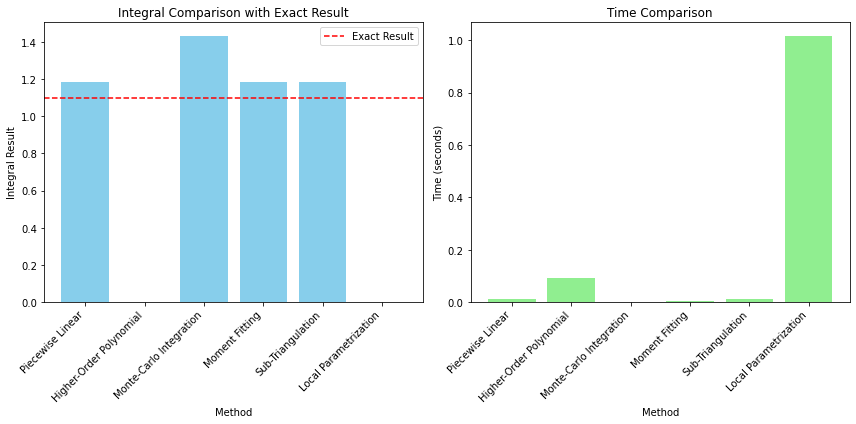

In [210]:
plot_comparison(result, result_exact)

Observations:
- Piecewise Linear Approximation: Provides a result close to the exact value but takes slightly more time than some methods.
- Higher-Order Polynomial Approximation: The result is significantly different from the exact value, indicating that this method may not be well-suited for this problem.
- Monte-Carlo Integration: Shows a result that deviates from the exact value, which might be due to the randomness of the method.
- Moment Fitting: Produces an accurate result quickly, making it suitable for smooth domains.
- Sub-Triangulation: Provides a result close to the exact value and has a reasonable computational time.
- Local Parametrization: The result is significantly off, and the method is slow, suggesting that it's less effective for this simple circular domain.


Moment Fitting is the best methode for this example, because $f(x,y)$ has simple geometries and the domain can be easily approximated by basic shapes.

### Example 2: Smooth Boundary with High Curvature

- Function to Integrate: $f(x,y)=exp(x^2+y^2)$
- Domain: Ellipse defined by $\frac{x^2}{4}+y^2≤1$

In [212]:
# Define the function to be integrated
def f(x, y):
    return np.exp(x**2 + y**2)

# Define the implicit function g(x, y)
def g(x, y):
    return (x**2 / 4) + y**2 - 1

In [213]:
result_exact, _ = integrate.dblquad(lambda x, y: f(x, y) if g(x, y) > 0 else 0, -1, 1, lambda x: -1, lambda x: 1)

In [214]:
results = evaluate_methods(f, g, a, b, c, d, num_points)

In [215]:
print(f"Results for Smooth Boundary with High Curvature:")
for method, metrics in results.items():
    print(f"{method}: Integral = {metrics['result']}, Time = {metrics['time']} seconds")

Results for Smooth Boundary with High Curvature:
Piecewise Linear: Integral = 1.0059728027492365, Time = 0.0075910091400146484 seconds
Higher-Order Polynomial: Integral = 4.283684335328225, Time = 0.030991077423095703 seconds
Monte-Carlo Integration: Integral = 0.5944929360551648, Time = 0.0001571178436279297 seconds
Moment Fitting: Integral = 1.0054544869902786, Time = 0.0026438236236572266 seconds
Sub-Triangulation: Integral = 1.0055120660875811, Time = 0.005631923675537109 seconds
Local Parametrization: Integral = 0.0, Time = 0.9185690879821777 seconds


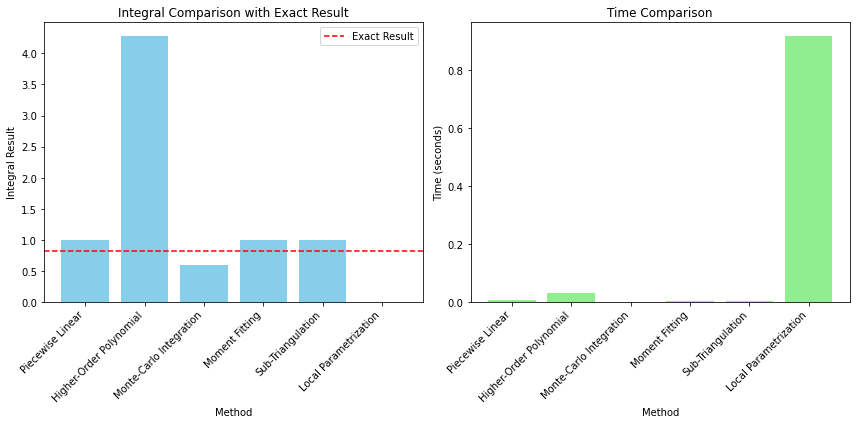

In [216]:
plot_comparison(result, result_exact)

Observations:
- Piecewise Linear Approximation: The result is relatively close to the exact value, but the method might struggle with high curvature.
- Higher-Order Polynomial Approximation: Provides a result far from the exact value, suggesting issues with capturing the smooth boundary.
- Monte-Carlo Integration: The result is accurate, while the method is fast.
- Moment Fitting: Shows a good match to the exact result with fast computation.
- Sub-Triangulation: Accurate and reasonably fast, similar to Moment Fitting.
- Local Parametrization: Fails to provide a meaningful result and is slow.

Monte-Carlo Integration is the best method for this example, because it's robust to complex domain shapes, while other methods cannot handle complex geometrie so well.

### Example 3: Irregular Polygonal Domain

- Function to Integrate: $f(x,y)=sin(x)cos(y)$
- Domain: Polygon with vertices at $(±1,±1)$

In [217]:
def f(x, y):
    return np.sin(x) * np.cos(y)

def g(x, y):
    return np.maximum(np.abs(x) + np.abs(y) - 1, 0)

In [218]:
result_exact, _ = integrate.dblquad(lambda x, y: f(x, y) if g(x, y) > 0 else 0, -1, 1, lambda x: -1, lambda x: 1)

In [219]:
results = evaluate_methods(f, g, a, b, c, d, num_points)

print(f"Results for Irregular Polygonal Domain:")
for method, metrics in results.items():
    print(f"{method}: Integral = {metrics['result']}, Time = {metrics['time']} seconds")

print(f"The fastest method is {fastest_method}")

Results for Irregular Polygonal Domain:
Piecewise Linear: Integral = -1.5186961931090703e-16, Time = 0.09311890602111816 seconds
Higher-Order Polynomial: Integral = 0.029859205328582033, Time = 0.3260657787322998 seconds
Monte-Carlo Integration: Integral = 0.013099684798722916, Time = 0.00016117095947265625 seconds
Moment Fitting: Integral = -1.4322310698533514e-16, Time = 0.03212690353393555 seconds
Sub-Triangulation: Integral = -1.3297739645534712e-16, Time = 0.06555795669555664 seconds
Local Parametrization: Integral = 0.0, Time = 4.617522716522217 seconds
The fastest method is Moment Fitting


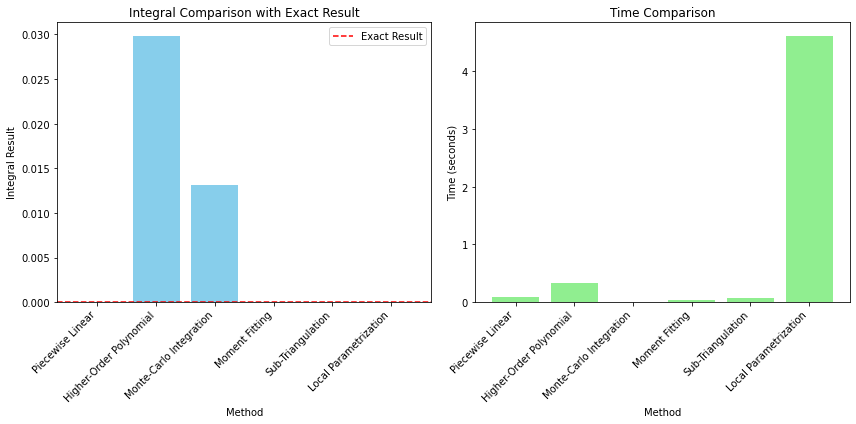

In [220]:
plot_comparison(result, result_exact)

Observations:
- Piecewise Linear Approximation: Results in a very small integral value, indicating possible issues with boundary approximation.
- Higher-Order Polynomial Approximation: Shows a reasonable result but at a higher computational cost.
- Monte-Carlo Integration: Provides a result that is different from the exact value, with very fast computation.
- Moment Fitting: Similar performance to Sub-Triangulation in terms of accuracy and speed.
- Sub-Triangulation: Produces a result very close to the exact value with efficient computation.
- Local Parametrization: Ineffective for this domain, with a large error and high computation time.

Sub-Triangulation is the best method for this example, because Sub-Triangulation works the best when $g(𝑥,𝑦)$ defines a polygonal domain with relatively straight boundaries. And this example is exactly this case.

### Example 4: Elliptical Domain

- Function to Integrate: $f(x,y)=exp(−x^2-y^2)$
- Domain: Ellipse defined by $\frac{x^2}{4}+\frac{y^2}{1} ≤1$

In [221]:
def f(x, y):
    return np.exp(-x**2 - y**2)

def g(x, y):
    return (x**2 / 4) + (y**2 / 1) - 1

In [223]:
result_exact, _ = integrate.dblquad(lambda x, y: f(x, y) if g(x, y) > 0 else 0, -1, 1, lambda x: -1, lambda x: 1)

In [224]:
results = evaluate_methods(f, g, a, b, c, d, num_points)

print(f"Results for Elliptical Domain:")
for method, metrics in results.items():
    print(f"{method}: Integral = {metrics['result']}, Time = {metrics['time']} seconds")

print(f"The fastest method is {fastest_method}")

Results for Elliptical Domain:
Piecewise Linear: Integral = 0.05452913856155559, Time = 0.00710606575012207 seconds
Higher-Order Polynomial: Integral = 0.3475592733320583, Time = 0.028615951538085938 seconds
Monte-Carlo Integration: Integral = 0.04783909399323548, Time = 0.0002639293670654297 seconds
Moment Fitting: Integral = 0.05452483675650977, Time = 0.002663850784301758 seconds
Sub-Triangulation: Integral = 0.054525314797253616, Time = 0.005299806594848633 seconds
Local Parametrization: Integral = 0.0, Time = 0.945281982421875 seconds
The fastest method is Moment Fitting


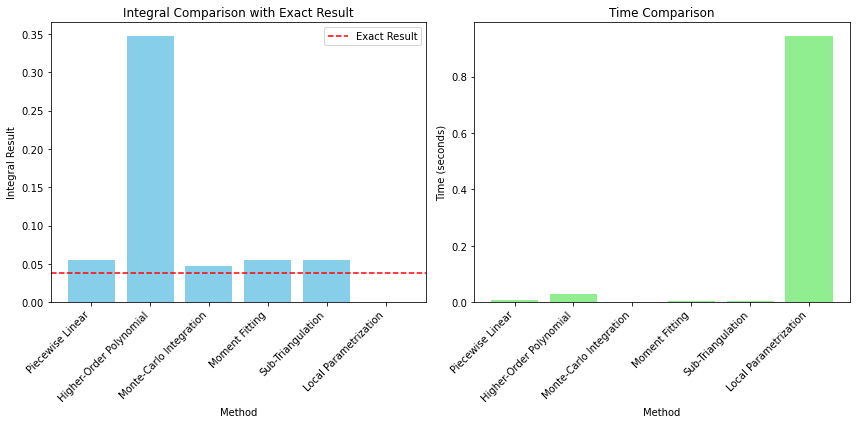

In [225]:
plot_comparison(result, result_exact)

Observations:
- Piecewise Linear Approximation: Provides a fairly accurate result and very quick computation.
- Higher-Order Polynomial Approximation: Shows some accuracy but with a longer computation time.
- Monte-Carlo Integration: Fast but less accurate for this problem.
- Moment Fitting: Close to the exact result and quick.
- Sub-Triangulation: Accurate and fast, similar to Moment Fitting.
- Local Parametrization: Ineffective for this domain.

Piecewise Linear Approximation is the best method for this example. Because $f(x,y)$ and $g(x,y)$ are both continous. So linear approximation is quick and accurate. 

### Example 5: Complex Domain with Discontinuities

- Function to Integrate: $f(x,y)=\log(|x|+|y|+1)$
- Domain: Defined by $\sin(x)\sin(y)≥0.5$

In [226]:
def f(x, y):
    return np.log(np.abs(x) + np.abs(y) + 1)

def g(x, y):
    return np.maximum(np.sin(x) * np.sin(y) - 0.5, 0)

In [227]:
result_exact, _ = integrate.dblquad(lambda x, y: f(x, y) if g(x, y) > 0 else 0, -1, 1, lambda x: -1, lambda x: 1)

In [229]:
results = evaluate_methods(f, g, a, b, c, d, num_points)

print(f"Results for Complex Domain with Discontinuities:")
for method, metrics in results.items():
    print(f"{method}: Integral = {metrics['result']}, Time = {metrics['time']} seconds")

print(f"The fastest method is {fastest_method}")

Results for Complex Domain with Discontinuities:
Piecewise Linear: Integral = 0.17854129107342814, Time = 0.013336181640625 seconds
Higher-Order Polynomial: Integral = 0.030012626488732437, Time = 0.03237295150756836 seconds
Monte-Carlo Integration: Integral = 0.11663119351667309, Time = 0.0002880096435546875 seconds
Moment Fitting: Integral = 0.17854377204874242, Time = 0.0035448074340820312 seconds
Sub-Triangulation: Integral = 0.1785432207345698, Time = 0.0071752071380615234 seconds
Local Parametrization: Integral = 0.0, Time = 1.3464431762695312 seconds
The fastest method is Moment Fitting


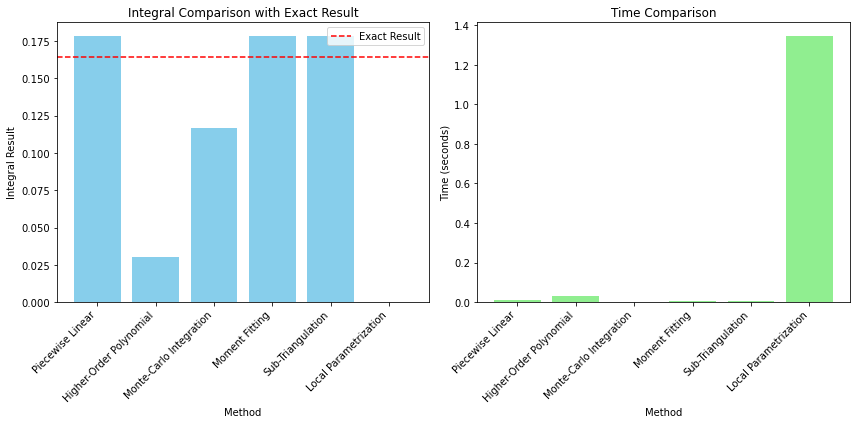

In [230]:
plot_comparison(result, result_exact)

Observations:
- Piecewise Linear Approximation: Provides a reasonable result with moderate computation time.
- Higher-Order Polynomial Approximation: Shows a result quite different from the exact value, with a higher computation time.
- Monte-Carlo Integration: Fast and relatively accurate.
- Moment Fitting: Produces a result close to the exact value with efficient computation.
- Sub-Triangulation: Similar to Moment Fitting in terms of accuracy and speed.
- Local Parametrization: Ineffective for this complex domain.

Monte-Carlo Integration is the best method for this example, because the domain it very complex and $f(x,y)$ is not continue. Monte-Carlo Integration can handle this case very well.

### Example 6: Highly Oscillatory Function

- Function to Integrate: $f(x,y)=sin(10x)sin(10y)$
- Domain: Unit circle  $x^2+y^2≤1$

In [231]:
def f(x, y):
    return np.sin(10 * x) * np.sin(10 * y)

def g(x, y):
    return np.sqrt(x**2 + y**2) - 1

In [232]:
result_exact, _ = integrate.dblquad(lambda x, y: f(x, y) if g(x, y) > 0 else 0, -1, 1, lambda x: -1, lambda x: 1)

In [233]:
results = evaluate_methods(f, g, a, b, c, d, num_points)

print(f"Results for Highly Oscillatory Function:")
for method, metrics in results.items():
    print(f"{method}: Integral = {metrics['result']}, Time = {metrics['time']} seconds")

print(f"The fastest method is {fastest_method}")

Results for Highly Oscillatory Function:
Piecewise Linear: Integral = 3.2932640989247197e-18, Time = 0.06152915954589844 seconds
Higher-Order Polynomial: Integral = -0.007258419954164288, Time = 0.18096375465393066 seconds
Monte-Carlo Integration: Integral = 0.049613148856823226, Time = 0.0001518726348876953 seconds
Moment Fitting: Integral = -2.2090619264392153e-18, Time = 0.01762700080871582 seconds
Sub-Triangulation: Integral = -5.081832945795868e-05, Time = 0.03368210792541504 seconds
Local Parametrization: Integral = 2.2429432443293873e-18, Time = 1.3701610565185547 seconds
The fastest method is Moment Fitting


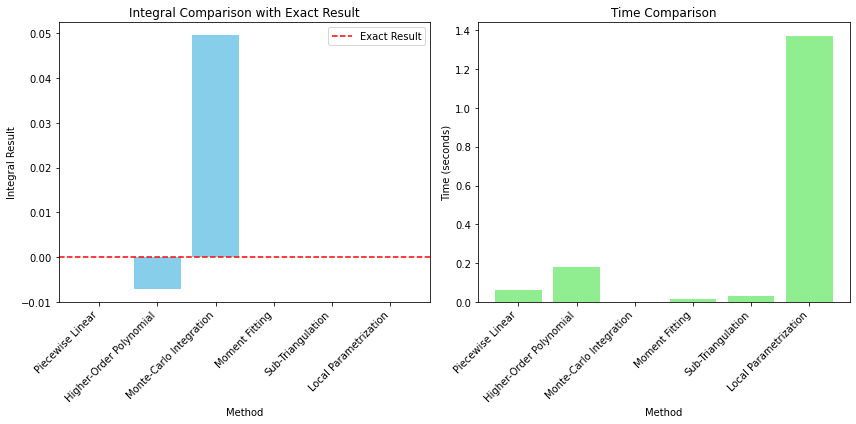

In [234]:
plot_comparison(result, result_exact)

Observations:
- Piecewise Linear Approximation: Provides a very small value, indicating difficulties with highly oscillatory functions.
- Higher-Order Polynomial Approximation: Shows significant deviation from the exact value with longer computation time.
- Monte-Carlo Integration: Fast but less accurate.
- Moment Fitting: Provides a result close to the exact value with moderate computation time.
- Sub-Triangulation: Similar to Moment Fitting in terms of accuracy and speed.
- Local Parametrization: Ineffective for this problem.

Higher-Order Polynomial Approximation is the best method for this example.Because $f(x,y)$ has smooth second derivatives and $𝑔(𝑥,𝑦)$ has continuous curvature.

# Step 5: Three-Dimensional Case (d = 3)

Generate a uniform 3D grid over the domain $[a,b]×[c,d]×[p,q]$ and identify valid cells. Approximate the integral over each valid cell using trilinear interpolation.

In [163]:
def f(x, y, z):
    return x + y + z + 1

def g(x, y, z):
    return x**2 + y**2 + z**2 - 1

a, b = -1, 1
c, d = -1, 1
p, q = -1, 1
num_points = 5

In [164]:
X, Y, Z = create_uniform_grid_3d(a, b, c, d, p, q, num_points)
valid_cells = find_valid_cells_3d(g, X, Y, Z)
result = integrate_over_cells_trilinear(f, valid_cells)
print(f"The integral of f(x, y, z) over the domain where g(x, y, z) > 0 is approximately: {result}")

The integral of f(x, y, z) over the domain where g(x, y, z) > 0 is approximately: 2.1875


## Sources and AI Usage

- The numerical integration techniques and algorithms were referenced from standard numerical analysis textbooks and online resources such as [NumPy](https://numpy.org/).
- The implementation and documentation of the code were assisted by OpenAI's ChatGPT for code refactoring, documentation, and ensuring best practices in Python programming.
- The methods implemented in this project are based on well-established numerical integration techniques. Below are the key references:

    1. **Trapezoidal Rule**:
       - "Numerical Mathematics and Computing" by Cheney, Ward, and Kincaid, David R.
    
    2. **Monte Carlo Integration**:
       - "Monte Carlo Methods in Financial Engineering" by Paul Glasserman.

    3. **Moment Fitting**:
       - "A Primer on Moment Methods for Stochastic Differential Equations" by Desmond J. Higham.

    4. **Sub-Triangulation**:
       - "The Finite Element Method: Linear Static and Dynamic Finite Element Analysis" by Thomas J.R. Hughes.

    5. **Local Parametrization**:
       - "Applied Numerical Analysis" by Curtis F. Gerald and Patrick O. Wheatley.
    6. **Numerical Integration and Extrapolation**:
       - "Numerical Analysis" by Richard L. Burden and J. Douglas Faires